<a href="https://colab.research.google.com/github/truongthuanr/transfer/blob/main/08_SSSMarket_truongthuan_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import seaborn as sns

from random import randint
from urllib.request import urlopen

from numpy import asarray

In [ ]:
train_url = "https://raw.githubusercontent.com/truongthuanr/self-project/main/dataset/sss/train.csv"
df = pd.read_csv(train_url)

In [ ]:
df.head(3)

,id,sku,short_description,price,discount,discount_rate,rating_average,review_count,order_count,favourite_count,thumbnail_url,categories,liked,rating_summary,brand,current_seller,other_sellers,configurable_options,extra_feature,cloth_type
0,0,4777164499549,\n \n- Loại : Quần Thể Thao Đen.\n- Kiểu Dáng ...,99000,101000,51,0.0,0,0,1,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 36387, ""sku"": ""5716562721707"", ""store_i...","[{""id"": 134556, ""name"": ""Mualayeushop"", ""link""...","[{""code"": ""option1"", ""name"": ""Size"", ""position...",[],top_t-shirt_sweatshirt shoe pants
1,1,2931572867679,\nÁo Len Nam Dày Bs33 được may từ chất liệu le...,400000,0,0,0.0,0,0,1,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 2, ""name"": ""Root"", ""is_leaf"": false}",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 10025, ""sku"": ""4689826428364"", ""store_i...",[],"[{""code"": ""option1"", ""name"": ""Màu"", ""position""...",[],sweater
2,2,6427102533481,\n \n- Loại : Quần Âu Thêu Vương Miện\n- Kiểu ...,159000,141000,47,4.5,14,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 9674, ""sku"": ""5288509925221"", ""store_id...",[],"[{""code"": ""option1"", ""name"": ""Size"", ""position...",[],watch shoe shirt_blouse pants


In [ ]:
from random import randint
from urllib.request import urlopen

In [ ]:
total_images = df.thumbnail_url.notna().sum()
total_images

4705

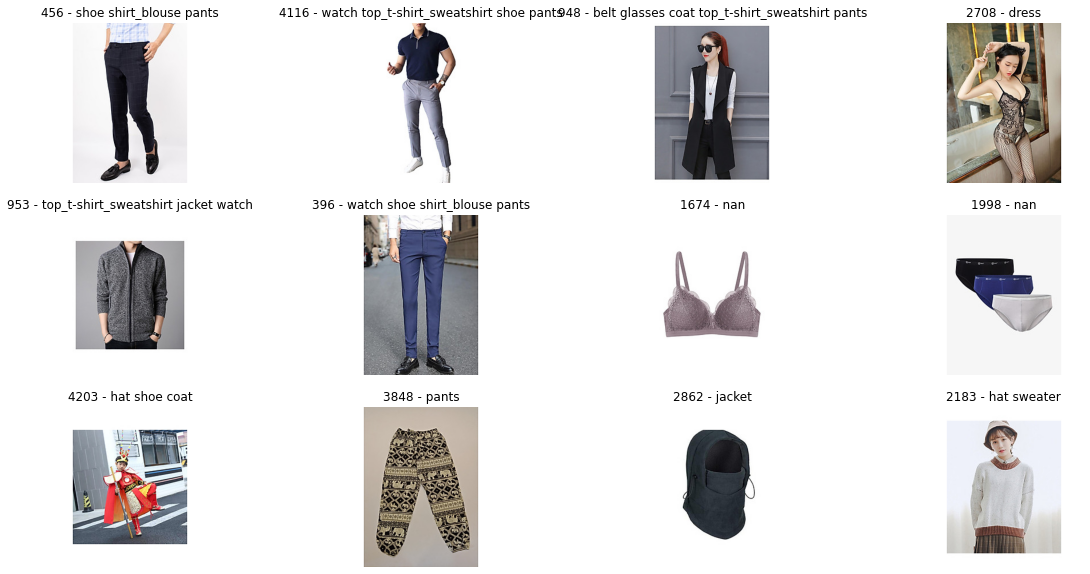

In [ ]:
# plot random 12 image
fig = plt.figure(figsize=(20,10))
for i in range(0,12):
  ax = plt.subplot(3,4,i+1)
  _i = randint(0,total_images)
  img = Image.open(urlopen(df.thumbnail_url[_i]))
  ax = plt.imshow(img)
  plt.title(f"{_i} - {df.cloth_type[_i]}")
  plt.axis("off")

# Check for label

In [ ]:
df.loc[df["cloth_type"]==' ',"cloth_type"] = np.NaN

In [ ]:
# create a list of list of labels 
labels = df.cloth_type.str.split(" ").tolist()
labels = [item if type(item) == list else [str(item)] for item in labels]
labels[:5]

[['top_t-shirt_sweatshirt', 'shoe', 'pants'],
 ['sweater'],
 ['watch', 'shoe', 'shirt_blouse', 'pants'],
 ['belt', 'dress', 'bag_wallet', 'shoe'],
 ['bag_wallet', 'dress', 'shoe']]

In [ ]:
# Count the apperence of label
all_label = [label for sub in labels for label in sub]
labels_count = Counter(all_label)
labels_count

Counter({'bag_wallet': 438,
         'belt': 410,
         'cardigan': 31,
         'coat': 152,
         'dress': 768,
         'glasses': 119,
         'hat': 195,
         'headband_head-covering_hair-accessory': 99,
         'jacket': 414,
         'jumpsuit': 25,
         'nan': 283,
         'pants': 1616,
         'scarf': 5,
         'shirt_blouse': 480,
         'shoe': 1520,
         'shorts': 479,
         'skirt': 750,
         'sweater': 116,
         'top_t-shirt_sweatshirt': 2382,
         'vest': 4,
         'watch': 463})


Create Mapping

In [ ]:
labels_count = Counter(all_label)
# sort by frequency
label_name = [tag for tag,count in labels_count.most_common()]
label_freq = [count for tag,count in labels_count.most_common()]

In [ ]:
label_map = {label_name[i]: i for i in range(0,len(label_name))}
inv_label_map = {i:label_name[i] for i in range(0,len(label_name))}


Whichs are the tops used label?

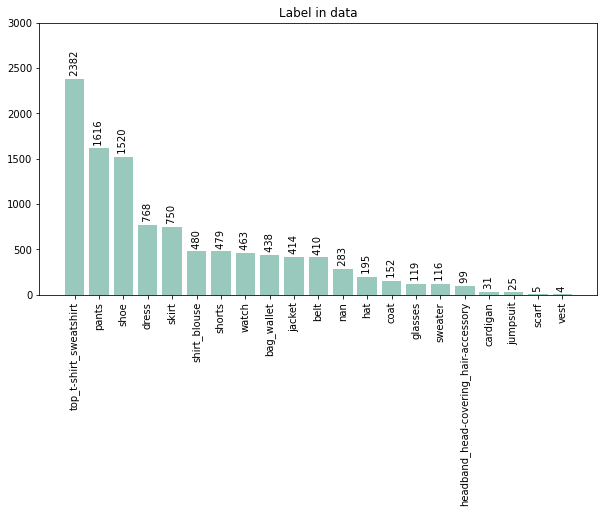

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.bar(label_name, label_freq, color="#99C8BC")
plt.title("Label in data")
plt.xticks(rotation=90)
for i, (tag,count) in enumerate(labels_count.most_common()):
  plt.text(i, count, f" {count} ", rotation=90, ha="center", va="bottom", color="black")
plt.ylim(0,3000);

Create a one hot encoding for one list of tags

In [ ]:
from numpy import asarray

In [ ]:
def one_hot_encoder(tags, mapping):
  # create empty vector
  encoding = np.zeros(len(label_map), dtype="uint")
  # mark 1 for each tag in the vector
  for tag in tags:
    encoding[label_map[tag]] = 1
  return encoding

In [ ]:
def load_dataset(images_url, labels, label_map):
  # images,  targets = list(), list()
  images = []
  targets = []
  for i in range(0,len(images_url)):
    # load_img
    img = Image.open(urlopen(images_url[i]))
    if img.mode != 'RGB': img = img.convert('RGB')

    # turn image in to array
    img = asarray(img)
    tags = labels[i]
    target = one_hot_encoder(tags, label_map)

    images.append(img)
    targets.append(target)

  X = asarray(images, dtype="uint8")
  y = asarray(targets, dtype="uint8")

  return X, y

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

''

In [ ]:
X, y = load_dataset(df.thumbnail_url, labels, label_map)

In [ ]:
np.savez_compressed("/content/drive/MyDrive/01_AI_ML/sss/sss_data_full_keepna.npz", X, y)

In [5]:

data = np.load("/content/drive/MyDrive/01_AI_ML/sss/sss_data_full_keepna.npz")
X, y = data["arr_0"], data["arr_1"]
print(f"Loaded: {X.shape} {y.shape}")

Loaded: (4705, 280, 280, 3) (4705, 21)


# How to evaluate model

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)

In [8]:
train_yhat = asarray([np.ones(y_train.shape[1]) for _ in range(y_train.shape[0])])

In [9]:

from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score

In [10]:
fbeta_score(y_train, train_yhat, beta=2, average='samples')

0.3545051627434874

In [9]:
f1_score(y_train, train_yhat, average='samples')

0.19044924451636544

In [10]:
X_train.shape

(3152, 280, 280, 3)

# Baseline Model

In [11]:
import sys
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import backend

In [12]:
def fbeta(y_true, y_pred, beta=1):
  # clip prediction
  y_pred = backend.clip(y_pred,0,1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta
  bb = beta**2
  fbeta_score = backend.mean((1+bb)*(p*r)/(bb*p+r+backend.epsilon()))
  return fbeta_score

In [13]:
fbeta(y_train, train_yhat, beta=2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.35450513328273336>

In [14]:
def define_model(in_shape=(280,280,3), out_shape=21):
  model = Sequential()
  model.add(Conv2D(32,
                   (3,3), 
                   activation="relu", 
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(Conv2D(32,
                   (3,3), 
                   activation="relu", 
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(64,
                   (3,3), 
                   activation="relu", 
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(Conv2D(64,
                   (3,3), 
                   activation="relu", 
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(128,
                   (3,3), 
                   activation="relu", 
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(Conv2D(128,
                   (3,3), 
                   activation="relu", 
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(MaxPool2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(out_shape, activation="softmax"))

  # Compile model
  # opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[fbeta])

  return model

In [15]:

# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  plt.subplot(211)
  plt.title("Cross Entropy Loss")
  plt.plot(history.history["loss"], color='blue', label='train')
  plt.plot(history.history['val_loss'],color='orange', label='test')

  # plot accuracy
  plt.subplot(212)
  plt.title("F1 Score")
  plt.plot(history.history["fbeta"], color='blue', label='train')
  plt.plot(history.history['val_fbeta'],color='orange', label='test')

In [17]:
# datagen = ImageDataGenerator(rescale=1.0/225.0)
# train_it = datagen.flow(X_train, y_train, batch_size=128)
# test_it = datagen.flow(X_test, y_test, batch_size=128)
model = define_model()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 280, 280, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 280, 280, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 140, 140, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 140, 140, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 140, 140, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 70, 70, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 70, 70, 128)       7

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=64,
                    validation_data=(X_test, y_test), 
                    epochs=50)

In [ ]:
model.save_weights('/content/drive/MyDrive/01_AI_ML/sss/model_dropout/model_dropout')

In [ ]:
!pip install tensorflow upgrade

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
